# Coursework 3: Bilinear Inverse Problems and Low-Rank Matrix Recovery

[x] By tick the checkbox, we hereby declare that this coursework report is our own and autonomous work. We have acknowledged all material and sources used in its preparation, including books, articles, reports, lecture notes, internet software packages, and any other kind of document, electronic or personal communication. This work has not been submitted for any other assessment.

##  Table of Contents for CW3 Report

#### Please use the table below, which made of hyperlinks to each section, to aid your review and understanding for layout of our document.

[3.1 Test Data Generation](#3.1TestDataGeneration)

[3.2 Matrix Completion Techniques](#3.2MatrixCompletionTechniques)

   [3.2.1 Alternating Minimization (AM)](#3.2.1AlternatingMinimization)

   [3.2.2 Iterative Hard Thresholding (IHT)](#3.2.2IterativeHardThresholding)
   
   [3.2.3 Iterative Shrinkage-Thresholding Algorithm (ISTA)](#3.2.3IterativeShrinkage-ThresholdingAlgorithm)
   
   [3.2.4 Lasso-ADMM](#3.2.4Lasso-ADMM)

[Highlight for Group 3](#Highlight)


Laslty, please <font color='red'>'run all'</font> this document once (this will be very quick), then all graphs/figures will be loaded in <font color='red'>if you have all the .jld2 files from our submission in the same directory</font>. Thank you.

<a id='3.1TestDataGeneration'></a>

## 3.1 Test Data Generation (10%)

We consider the low-rank matrix completion problem given by 
$$
    \boldsymbol{y} = \mathcal{P}_{\Omega}(\boldsymbol{X}) 
$$
where $\boldsymbol{X} \in \mathbb{R}^{m \times n}$ is a low rank matrix of rank $r$. 

Data generation: Write $\boldsymbol{X} = \boldsymbol{U} \boldsymbol{G} \boldsymbol{V}^{\mathsf{T}}$, where $\boldsymbol{U} \in \mathbb{R}^{m \times r}$, $\boldsymbol{G} \in \mathbb{R}^{r \times r}$, and $\boldsymbol{V} \in \mathbb{R}^{n \times r}$ are matrices with i.i.d. $\mathcal{N}(0,1)$ Gaussian entries. (Note that by $\boldsymbol{X} = \boldsymbol{U} \boldsymbol{G} \boldsymbol{V}^{\mathsf{T}}$ we are not talking about SVD.)

Design and implement a function `LRMC_data_gen` to generate test data. Provide necessary documentation.

The Random Gaussian Matrix for data generation

In [1]:
#helper functions
using LinearAlgebra
using StatsBase
using Random
using JLD2
function RandomGaussianMatrix(M,N)
    Random.seed!(3)
    A = randn(M,N)
    for i in 1:N
    norm_A_col = norm(A[:,i])
    A[:,i] = A[:,i] / norm_A_col
    end
    return A
end

RandomGaussianMatrix (generic function with 1 method)

The LMRC_data_gen function generates low rank matrix X, the projection matrix A, and the vector of revealed elements y.

In [2]:
function LRMC_data_gen(m,n,r,Ω)
    Random.seed!(3)
    U = RandomGaussianMatrix(m,r)
    G = RandomGaussianMatrix(r,r)
    V = RandomGaussianMatrix(n,r)
    X = U * G * V'

    T = sample(1:m*n, Ω, replace=false)
    A = zeros(Ω,m*n)
    index = 1
    for i in 1:Ω
        A[i,T[index]] = 1
        index += 1
    end
    y = A * vec(X)
    return X,A,y,sort(T)
end

LRMC_data_gen (generic function with 1 method)

<a id='3.2MatrixCompletionTechniques'></a>
# 3.2 Matrix Completion Techniques

In the following, the suggested simulation setup is that $m = 32$, $n=48$, $r$ varies in $2:2:8$, and $|\Omega|/mn$ varies in $\{1/8,~ 1/6,~ 1/4,~ 1/2\}$. 

<a id='3.2.1AlternatingMinimization'></a>
## 3.2.1 Alternating Minimization (20%)

Design, implement, and run tests for the alternating minimization method for low-rank matrix completion. Use the function name `LRMCRec_AM`. Provide necessary documentation.

<u>**Brief explaination of AM function**</u>

For the AM algorithm, we optimize P and Q in each iteration, we optimize one of them while fixing the other. <br>
This is done by optimizing each row of P and Q in an iterative manner. <br>
Every row optimisation of P or Q correspounds to each column of X, based on the revealed elements. <br>
This algorithm achieves **high convergence speed and results in low final residue and ground truth error.**

In [3]:
function LRMCRec_AM(Ω,r)
    m = 32
    n = 48
    X,A,y,T = LRMC_data_gen(m,n,r,Ω)

    P = RandomGaussianMatrix(m, r)
    Q = RandomGaussianMatrix(n,r)
    current_norm = norm(y-A*vec(P*Q'))
    past_norm = current_norm
    iters = 1
    Norms = []
    while true
        column_counter = 0
        for i in 1:n
            extracted_P = A[:,column_counter+1:column_counter+m]*P
            Q[i,:] = pinv(extracted_P) * y
            column_counter += m
            current_norm = norm(y-A * reshape(P * Q',m*n,1))
            push!(Norms,current_norm)
        end
        column_counter = 0
        for i in 1:m
            extracted_Q = A[:,i:m:m*(n-1)+i] * Q
            P[i,:] = pinv(extracted_Q) * y
            current_norm = norm(y-A * reshape(P * Q',m*n,1))
            push!(Norms,current_norm)
        end
        if(current_norm>past_norm || current_norm < 1e-8 || iters > 300)
            break
        end
        past_norm = current_norm
    end
    ground_truth_difference = norm(X - P * Q')
    return P,Q,ground_truth_difference,current_norm,Norms
end

LRMCRec_AM (generic function with 1 method)

## Testing LRMCRec_AM Function

<u>Plotting Grouth truth error and Final residue against rank and |Ω|</u> in the below code.

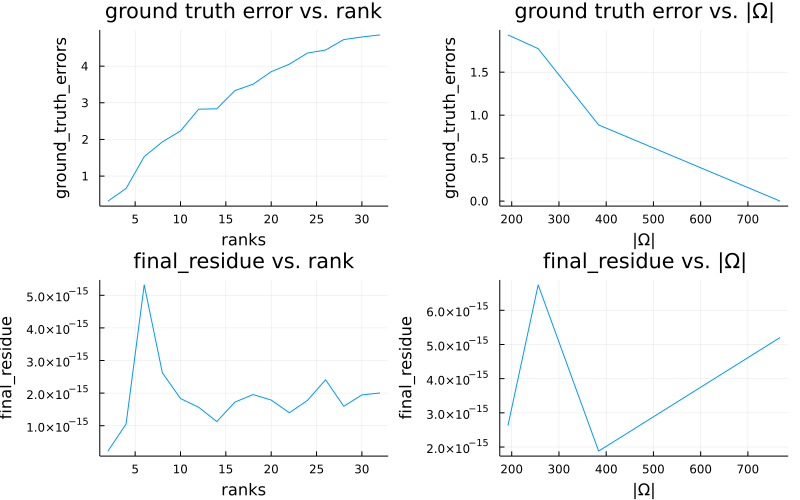

In [4]:
using Plots
using JLD2
allow_run = false
if(allow_run)
    ground_truth_errors_r = [(LRMCRec_AM(192,r)[3]) for r in 2:2:32]
    ground_truth_errors_Ω =[(LRMCRec_AM(Ω,8)[3]) for Ω in (Ω_s = [192,256,384,768])]
    p1 = plot([2:2:32],ground_truth_errors_r,title = "ground truth error vs. rank",xlabel = "ranks", ylabel = "ground_truth_errors")
    p2 = plot(Ω_s,ground_truth_errors_Ω,title = "ground truth error vs. |Ω|",xlabel = "|Ω|", ylabel = "ground_truth_errors")
    final_residue_r = [(LRMCRec_AM(192,r)[4]) for r in 2:2:32]
    final_residue_Ω = ground_truth_errors_Ω =[(LRMCRec_AM(Ω,8)[4]) for Ω in (Ω_s = [192,256,384,768])]
    p3 = plot([2:2:32],final_residue_r,title = "final_residue vs. rank",xlabel = "ranks", ylabel = "final_residue")
    p4 = plot(Ω_s,final_residue_Ω,title = "final_residue vs. |Ω|",xlabel = "|Ω|", ylabel = "final_residue")
    str = string("ground_truth_error_plots_AM.jld2")
    results = [p1,p2,p3,p4]
    @save str results
else
    str = string("ground_truth_error_plots_AM.jld2")
    @load str results
    p1,p2,p3,p4 = results
end

display(plot(p1, p2,p3,p4,layout = (2, 2), legend = false, windowsize=(800, 500)))

<u>**Summary Notes**</u>

Matrix **X** with higher ranks would results higher ground truth error in the end $\|x_{true} - PQ^T\|^2_2$, <br>

Difference in rank and $|\Omega|$ doesn't seems to have significant impact on the final residue. **Alternating minimisation can always recover the signal.**
<br>
<br>

Below is code for <u>Plotting Residue against iterations for different values of |Ω| and varying rank within each sub graph.</u>

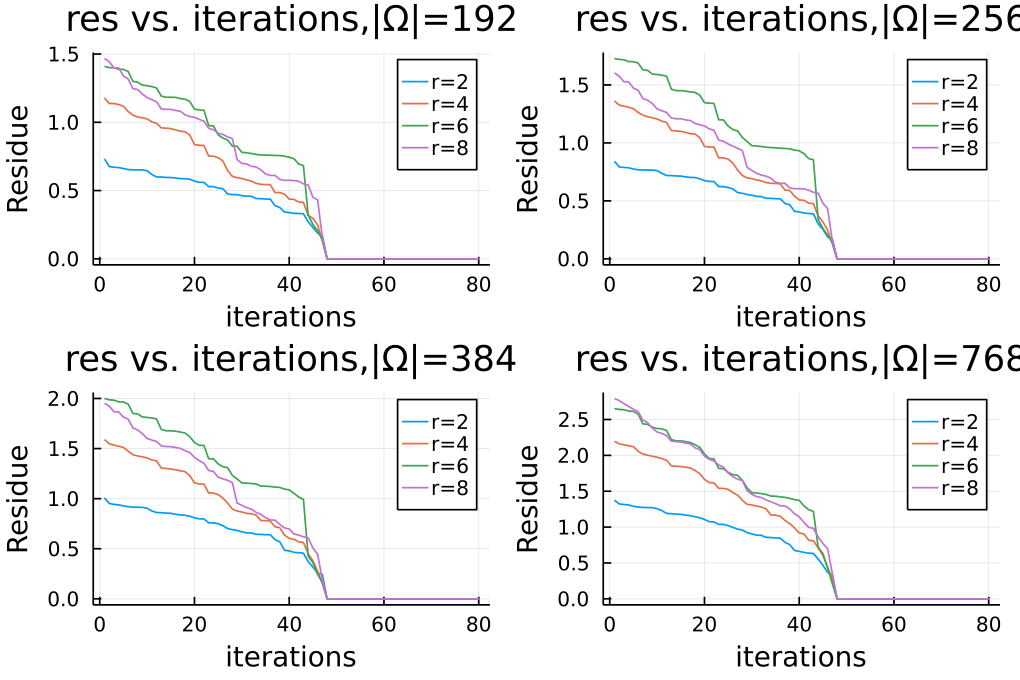

In [5]:
using Plots
plot_arr = Plots.Plot{Plots.GRBackend}[]
p = Plots.Plot{Plots.GRBackend}
Ω_s = [192,256,384,768]
for Ω in Ω_s
    r_s = [2,4,6,8]
    for r in r_s 
        norms = LRMCRec_AM(Ω,r)[5]
        if(r == r_s[1])
            p = plot(range(1,stop=length(norms)),norms,label="r=$(r)", title="res vs. iterations,|Ω|=$(Ω)",ylabel="Residue", xlabel="iterations", fmt = :png,dpi=170)
        else
            p = plot!(range(1,stop=length(norms)),norms,label="r=$(r)", title="res vs. iterations,|Ω|=$(Ω)",ylabel="Residue", xlabel="iterations", fmt = :png,dpi=170)
        end
    end 
    push!(plot_arr, p) 
end
plot(plot_arr[1],plot_arr[2],plot_arr[3],plot_arr[4],layout = (2, 2))

<u>**Summary Notes**</u>

**Lower ranks** starts with **lower residue**, but **different ranks** all takes the **same iterations to converge**.(the optimisation process on every column of P or Q is counted as an iteration)

<a id='3.2.2IterativeHardThresholding'></a>
## 3.2.2 Iterative Hard Thresholding (IHT) (20%)

Design, implement, and run simple tests for the IHT algorithm for low-rank matrix completion. Use the function name `LRMCRec_IHT`. Provide necessary documentation. 

<u>**Brief explaination of IHT function**</u>
<br>
The proximal operator of rank indicator function is given as <br>
<br>
$ X^* = Prox_{\gamma \delta(rank \leq r)}(Z) $ <br>
<br>
$=arg min \delta(rank(X)\leq r)+\frac{1}{2\gamma}\|X-Z\|^2_F$ <br>
<br>
The IHT algorithm for low rank matrix recovery is given as <br>
<br>
$X^{l+1} = H_{rank-r}(X^l+\tau A^Tmatriaxlize(y-Avec(X^l)))$<br>
<br>
To apply the hard threshold on the rank of $X^l$ we compute SVD on $X^l$ every time we completed the update of $X^l$ and keep the first r singular values and set the rest to 0.
 

In [6]:
##Supplmentary functions for LRMCRec_IHT function

# full SVD:
using LinearAlgebra
function full_svd_detail(mat)
    U_f, S_f, V_f = svd(mat, full=true);
    #@show U_f;
    S_f = Diagonal(S_f);
    u_c = size(U_f, 2);
    s_r = size(S_f, 1);
    s_c = size(S_f, 2);
    v_c = size(V_f, 2);

    if (u_c > s_r)
        S_f2 = zeros(u_c, s_c);
        S_f2[1:s_r, 1:s_c] = S_f;
    elseif (s_c < v_c)
        S_f2 = zeros(s_r, v_c);
        S_f2[1:s_r, 1:s_c] = S_f;
    else
        S_f2 = S_f;
    end
    return U_f, S_f2, V_f
end

function hard_threshold(r,X_l,m)
    U,singular_value,V = full_svd_detail(X_l)
    for i in (r+1):m                 #where 12 is r
        singular_value[i,i] = 0
    end
    Xl_reconstructed = U * singular_value * V'
    return Xl_reconstructed
end

hard_threshold (generic function with 1 method)

In [7]:
function LRMCRec_IHT(τ,Ω,r)
    #initalization
    m = 32
    n = 48
    X,A,y,T = LRMC_data_gen(m,n,r,Ω)                      #generate the ground truth x
    
    #A = RandomGaussianMatrix(Ω,m * n)

    X_l = RandomGaussianMatrix(m,n)                #initialize X_l randomly
    x_l_transformed = reshape(X_l,m*n,1)           #vectorize
    
    current_norm = norm(y - A * x_l_transformed)   #Norm calculation
    past_norm = current_norm
    
    iters = 1                                      #Iteration Coutner
    norm_list= []
    append!(norm_list, current_norm)
    
    while true
        
        X_l = reshape(X_l,m*n,1)                   #vectorize
        Ax_l = A * X_l                             
        sub_term = y - Ax_l
        restored = reshape(A' * sub_term,m,n)      #Restore back to matrix form m*n
        X_l = reshape(X_l,m,n)                     #Restore X_l back to matrix form

        X_l = X_l + τ .* restored

        X_l = hard_threshold(r,X_l,m)                            #Apply Hard threshhold
        current_norm = norm(y - A * reshape(X_l,m*n,1))    #Calculate current_norm including vectorize

        append!(norm_list, current_norm)
        
        if(current_norm < 1e-4 || current_norm > past_norm || iters > 300)    #3 Exit Conditions Applied
            break
        end
        past_norm = current_norm                              #Update vlaue of past_norm after every iteration
        
        iters += 1
    end
    ground_truth_error = norm(X-X_l)
    return X_l, norm_list,ground_truth_error,current_norm


end

LRMCRec_IHT (generic function with 1 method)

## Testing LMRCRec_IHT function

<u>Plotting residue against iterations for different **τ** values when |Ω| = 192</u>

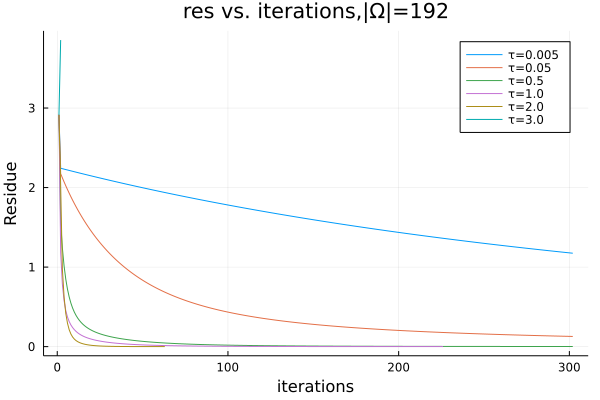

In [8]:
using Plots
τ_s = [0.005, 0.05, 0.5, 1, 2, 3] #Trying out different τ values
for τ in τ_s 
X,norms = LRMCRec_IHT(τ,192,8)
    if(τ == τ_s[1])
        p = plot(range(1,stop=length(norms)),norms,label="τ=$(τ)", title="res vs. iterations,|Ω|=192",ylabel="Residue", xlabel="iterations", fmt = :png,dpi=100)
    else
        p = plot!(range(1,stop=length(norms)),norms,label="τ=$(τ)", title="res vs. iterations,|Ω|=192",ylabel="Residue", xlabel="iterations", fmt = :png,dpi=100)
    end
end 
display(plot(p))

<u>**Summary Notes**</u>

$\tau$ is the step size of update in the iteration. <br>

We observe that, for the case of $|\Omega| = 192$, $\boldsymbol\tau$ **values close to 2 has best performance** .<br>

When the Value of $\tau$ is **too small** can cause **slow rate to convergence due to small step size**. <br>
When the Value of $\tau$ is **too big** can **cause divergence** as shown for $\tau = 3$<br>
<br>
<br>
<u>Plotting residue against iterations for different **rank** values when |Ω| = 192</u>

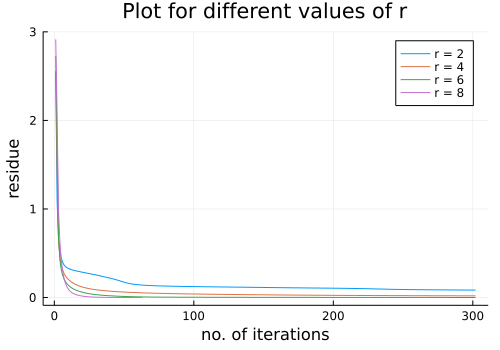

In [9]:
r = [2, 4, 6, 8]
X,list_1 = LRMCRec_IHT(2,192,r[1])
X,list_2 = LRMCRec_IHT(2,192,r[2])
X,list_3 = LRMCRec_IHT(2,192,r[3])
X,list_4 = LRMCRec_IHT(2,192,r[4])

plot(range(1,stop=length(list_1)),list_1, label = "r = 2")
plot!(range(1,stop=length(list_2)),list_2, label = "r = 4")
plot!(range(1,stop=length(list_3)),list_3, label = "r = 6")
display(plot!(range(1,stop=length(list_4)),list_4, label = "r = 8", 
        title = "Plot for different values of r", xlabel="no. of iterations", ylabel="residue", windowsize=(500, 350)))

<u>**Summary Notes**</u>

From our tests, we observed for the **bigger r values** we could have **faster convergence in fewer iterations**. This is expected since higher rank could contain more information.
<br>
<br>

<u>Plotting norm against iterations for different **|Ω|** values.</u>

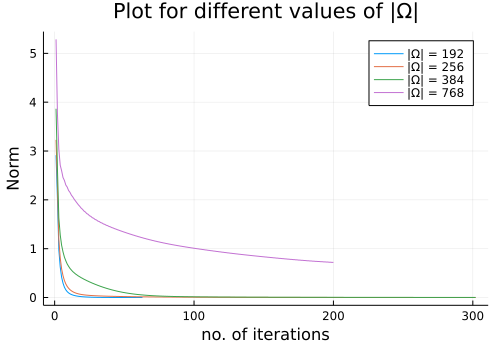

In [10]:
Ω = [192, 256, 384, 768]
X,list_1 = LRMCRec_IHT(2,Ω[1],8)
X,list_2 = LRMCRec_IHT(2,Ω[2],8)
X,list_3 = LRMCRec_IHT(2,Ω[3],8)
X,list_4 = LRMCRec_IHT(2,Ω[4],8)

plot(range(1,stop=length(list_1)),list_1, label = "|Ω| = 192")
plot!(range(1,stop=length(list_2)),list_2, label = "|Ω| = 256")
plot!(range(1,stop=length(list_3)),list_3, label = "|Ω| = 384")
display(plot!(range(1,stop=length(list_4)),list_4, label = "|Ω| = 768", 
        title = "Plot for different values of |Ω|", xlabel="no. of iterations", ylabel="Norm", windowsize=(500, 350)))

<u>**Summary Notes**</u>

Provided with same value of $\tau$, smaller $|\Omega|$ would give better performance

<u>Plotting residue against iterations for different **τ** values and varying |Ω| in each subgraph.</u>

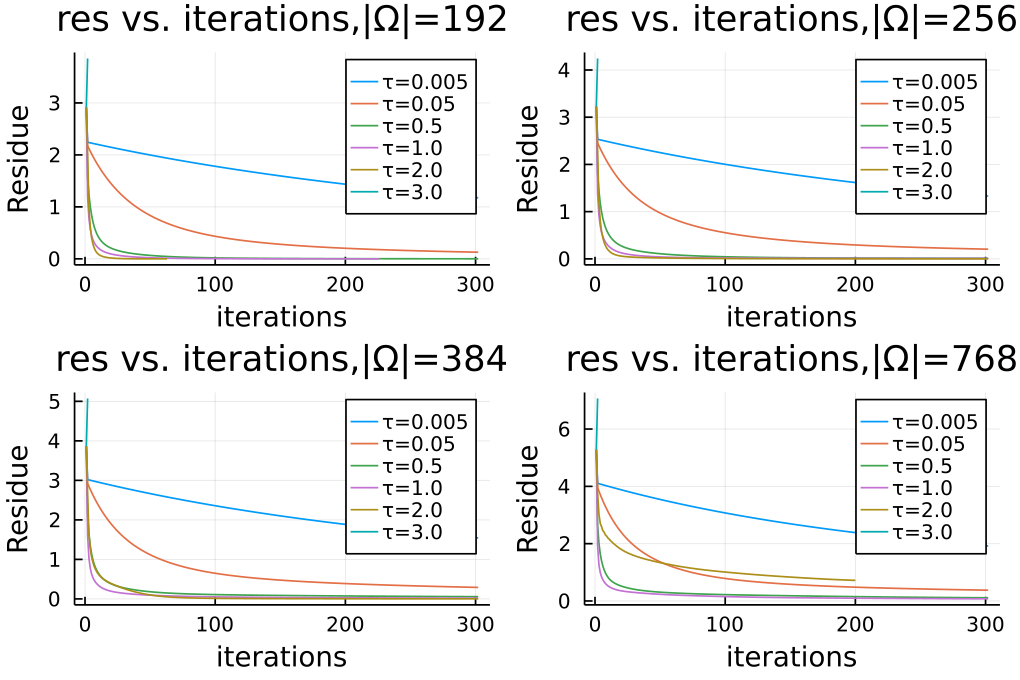

In [11]:
using Plots
plot_arr = Plots.Plot{Plots.GRBackend}[]
p = Plots.Plot{Plots.GRBackend}
Ω_s = [192,256,384,768]
for Ω in Ω_s
    τ_s = [0.005, 0.05, 0.5, 1, 2, 3] #Trying out different τ values
    # Comparing algorithms for τ
    for τ in τ_s 
        X,norms = LRMCRec_IHT(τ,Ω,8)
        if(τ == τ_s[1])
            p = plot(range(1,stop=length(norms)),norms,label="τ=$(τ)", title="res vs. iterations,|Ω|=$(Ω)",ylabel="Residue", xlabel="iterations", fmt = :png,dpi=170)
        else
            p = plot!(range(1,stop=length(norms)),norms,label="τ=$(τ)", title="res vs. iterations,|Ω|=$(Ω)",ylabel="Residue", xlabel="iterations", fmt = :png,dpi=170)
        end
    end 
    push!(plot_arr, p) 
end
plot(plot_arr[1],plot_arr[2],plot_arr[3],plot_arr[4],layout = (2, 2))

<u>Plotting Ground Truth Error against rank, τ and Ω .</u>

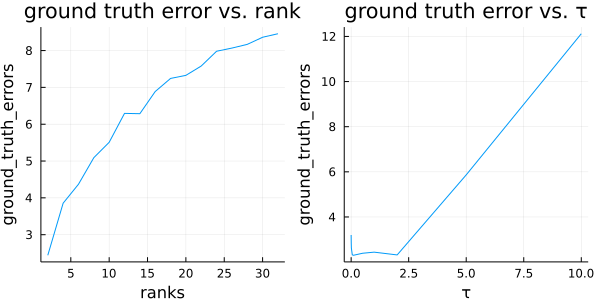

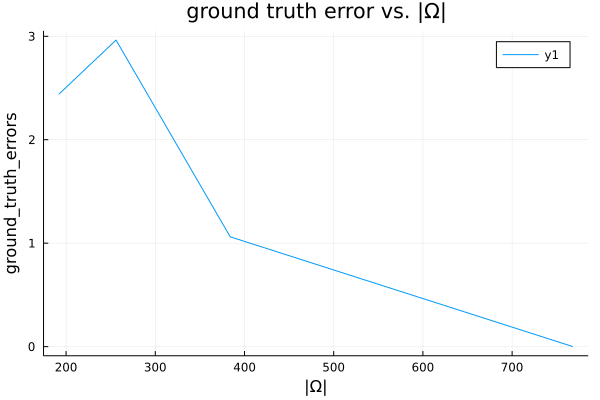

In [12]:
using Plots
using JLD2
allow_run = false
if(allow_run)
    ground_truth_errors_r = [(LRMCRec_IHT(1,192,r)[3]) for r in 2:2:32]
    ground_truth_errors_τ = [(LRMCRec_IHT(τ,192,2)[3]) for τ in (τ_s = [0.0001,0.0005,0.001,0.005, 0.01, 0.05,0.1,0.5,1,2,5,10])]
    ground_truth_errors_Ω =[(LRMCRec_IHT(1,Ω,2)[3]) for Ω in (Ω_s = [192,256,384,768])]
    str = string("ground_truth_error_plots_iht.jld2")
    results = [ground_truth_errors_r,ground_truth_errors_τ,τ_s,ground_truth_errors_Ω,Ω_s]
    @save str results
else
    str = string("ground_truth_error_plots_iht.jld2")
    @load str results
    ground_truth_errors_r,ground_truth_errors_τ,τ_s,ground_truth_errors_Ω,Ω_s = results
end
p1 = plot([2:2:32],ground_truth_errors_r,title = "ground truth error vs. rank",xlabel = "ranks", ylabel = "ground_truth_errors")
p2 = plot(τ_s,ground_truth_errors_τ,title = "ground truth error vs. τ",xlabel = "τ", ylabel = "ground_truth_errors")
p3 = plot(Ω_s,ground_truth_errors_Ω,title = "ground truth error vs. |Ω|",xlabel = "|Ω|", ylabel = "ground_truth_errors")
display(plot(p1, p2,layout = (1, 2), legend = false, windowsize=(600, 300)))
display(plot(p3))

<u>**Summary Notes**</u>

**Greater ranks** results in **higher ground truth error**. **Large $\boldsymbol\tau$** will also result in **high ground truth error** as expected(higher than threshold)<br>

More revealed index would results in low ground truth error as more details are being revealed. <br>

In comparision **higher $\Omega$** results in slightly **higher final residue** as there are more details to fit in the optimisation process
<br>
<br>
### <u>Plotting Ground Truth Error and Final Residue as Contour and Surface plot for different values of τ and Ω .</u>

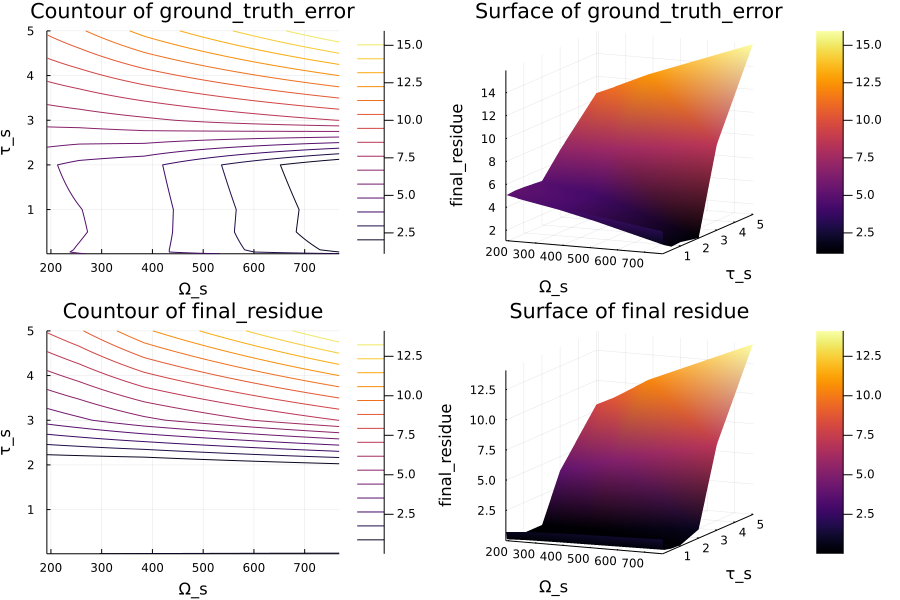

In [13]:
allow_run = false
if(allow_run)
    τ_s = [0.01, 0.05, 0.1, 0.5, 1,2,3,5]
    Ω_s = [192,256,384,768]
    final_residue = [(LRMCRec_IHT(τ,Ω,8)[4]) for τ in τ_s, Ω in Ω_s]
    ground_truth_error = [(LRMCRec_IHT(τ,Ω,8)[3]) for τ in τ_s, Ω in Ω_s]
    str = string("ground_truth_error_plots3d_iht.jld2")
    results = [Ω_s,τ_s,final_residue,ground_truth_error]
    @save str results
else
    str = string("ground_truth_error_plots3d_iht.jld2")
    @load str results
    Ω_s,τ_s,final_residue,ground_truth_error = results
end
p1 = plot(contour(Ω_s, τ_s, ground_truth_error, title="Countour of ground_truth_error", xaxis="Ω_s", yaxis="τ_s", fill=false))
p2 = plot(surface(Ω_s, τ_s, ground_truth_error, title="Surface of ground_truth_error", xlabel="Ω_s", ylabel="τ_s", zlabel="final_residue"))
p3 = plot(contour(Ω_s, τ_s, final_residue, title="Countour of final_residue", xaxis="Ω_s", yaxis="τ_s", fill=false))
p4 = plot(surface(Ω_s, τ_s, final_residue, title="Surface of final residue", xlabel="Ω_s", ylabel="τ_s", zlabel="final_residue"))
display(plot(p1, p2, p3, p4,layout = (2, 2), legend = false, windowsize=(900, 600)))

<u>**Summary Notes**</u>

**Greater $\boldsymbol\Omega$** gives **smaller ground truth error**. For $\tau$ values within the threshold $[0,2]$, greater $\tau$ can have smaller ground truth error but higher final residue.

<a id='3.2.3IterativeShrinkage-ThresholdingAlgorithm'></a>
## 3.2.3 Iterative Shrinkage-Thresholding Algorithm (ISTA) (25%)

Design, implement, and run simple tests for ISTA (to solve the Lasso formulation) for low-rank matrix completion. Use the function name `LRMCRec_ISTA`. Provide necessary documentation. Use simulations to discuss the choice of parameters.

<u>**Brief explaination of ISTA function**</u>

For the ISTA algorithm for low rank matrix completion we solve the Lasso problem of $min \frac {1}{2}\|y-Avec(X)\|^2_2+\lambda\|X\|_*$ <br>

Similiar to the common ISTA discussed in CW2, here in the application of low rank matrix completion we use the nuclear norm to replace the ordinary L1 norm.<br>

Every iteration after we compute the new $X^l$ values, we do singular value decomposition and set all the singular values smaller the threshold to 0 and others minus the threshold to regularize the $x^l$ values.<br>

Has the form of $X^{l+1}=\eta_\sigma(X^l+\tau A^*matraxlize(y-Avec(X^l));\lambda\tau^l)$

In [14]:
function soft_treshhold(x,A,τ,λ,y,m,n)
    x_new = x + τ*transpose(A)*(y-A*x)
    x_new = reshape(x_new,m,n)
    U,Σ,V = full_svd_detail(x_new)
    for i in 1:m
        if Σ[i,i] < τ * λ                      #Σ[i,i] always non-negative
            Σ[i,i]=0
        else 
            Σ[i,i] -= τ * λ
        end
    end
    x_new = U * Σ * V'
    return x_new
end


function LRMCRec_ISTA(τ,λ,Ω,r)
    #initalization
    m = 32
    n = 48
    
    
    X,A,y,T = LRMC_data_gen(m,n,r,Ω)
    #A = RandomGaussianMatrix(Ω,m * n)

    x_l = RandomGaussianMatrix(m,n)                #initialize X_l randomly
    x_l_transformed = reshape(x_l,m*n,1)           #vectorize
    

    current_norm = norm(y - A * x_l_transformed)
    past_norm = current_norm
    
    iterations = 1
    norm_list= []
    append!(norm_list, current_norm)
    while true
        x_l_transformed = reshape(x_l,m*n,1)
        x_l = soft_treshhold(x_l_transformed,A,τ,λ,y,m,n)
        x_l_transformed = reshape(x_l,m*n,1)
        
        y_res = y - A*x_l_transformed;
        
        
        current_norm = norm(y_res)
        append!(norm_list, current_norm)
        if current_norm < 1e-4 || iterations > 600 || current_norm > past_norm
            break
        end
        past_norm = current_norm                              #Update vlaue of past_norm after every iteration
        
        iterations = iterations + 1
    end
    ground_truth_error = norm(X-x_l)
    final_residue = current_norm
    return x_l,norm_list,ground_truth_error,final_residue
end

LRMCRec_ISTA (generic function with 1 method)

## Testing LRMCRec_ISTA Function

<u>Plotting Residue against Iterations for different values of τ when |Ω| = 192.</u>

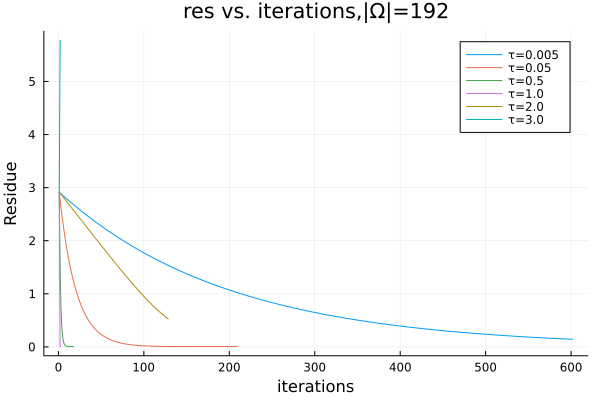

the τ threshold is 2.0


In [15]:
using Plots
τ_s = [0.005, 0.05, 0.5, 1, 2, 3] #Trying out different τ values
for τ in τ_s 
norms = LRMCRec_ISTA(τ,0.005,192,8)[2]
    if(τ == τ_s[1])
        p = plot(range(1,stop=length(norms)),norms,label="τ=$(τ)", title="res vs. iterations,|Ω|=192",ylabel="Residue", xlabel="iterations", fmt = :png,dpi=100)
    else
        p = plot!(range(1,stop=length(norms)),norms,label="τ=$(τ)", title="res vs. iterations,|Ω|=192",ylabel="Residue", xlabel="iterations", fmt = :png,dpi=100)
    end
end 
display(plot(p))

A = LRMC_data_gen(32,48,8,192)[2]
#A = RandomGaussianMatrix(192,32 * 48)
u,Σ,v = svd(A' * A)
σ_max = maximum(Σ)
τ_threshold = 2/σ_max
println("the τ threshold is ",τ_threshold)

<u>**Summary Notes**</u>

$\boldsymbol\tau$ values **greater than the threshold diverges**.<br>

**Too small** $\tau$ takes **too long to converge**. <br>

In our case, $\boldsymbol\tau$ **value = 1** gives the **best performance**. 
<br>
<br>

<u>Plotting Residue against Iterations for different values of λ.</u>

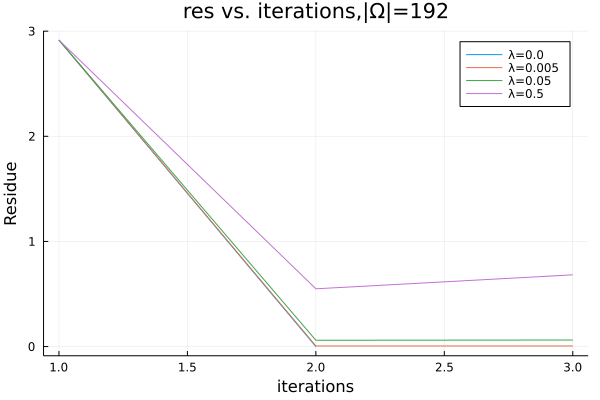

In [16]:
λ_s = [0,0.005, 0.05, 0.5] #Trying out different τ values
for λ in λ_s 
norms = LRMCRec_ISTA(1,λ,192,8)[2]
    if(λ == λ_s[1])
        p = plot(range(1,stop=length(norms)),norms,label="λ=$(λ)", title="res vs. iterations,|Ω|=192",ylabel="Residue", xlabel="iterations", fmt = :png,dpi=100)
    else
        p = plot!(range(1,stop=length(norms)),norms,label="λ=$(λ)", title="res vs. iterations,|Ω|=192",ylabel="Residue", xlabel="iterations", fmt = :png,dpi=100)
    end
end 
display(plot(p))

<u>**Summary Notes**</u>

Small $\lambda$ values **does not restrict** the value of $X^l$ in each iteration process.

Large $\lambda$ values **restrict** the value of $X^l$ too much, forcing its elements to be too small to derive from the minimium value.
<br>
<br>

<u>Plotting Ground Truth Error against rank, τ, $\lambda$ and |Ω| .</u>

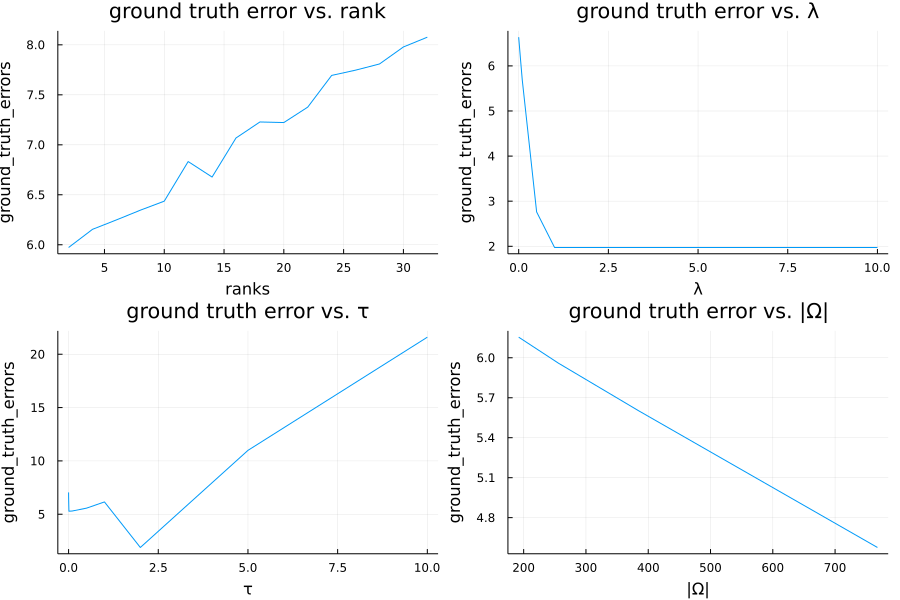

In [17]:
using Plots
using JLD2
allow_run = false
if(allow_run)
    ground_truth_errors_r = [(LRMCRec_ISTA(1,0.05,192,r)[3]) for r in 2:2:32]
    ground_truth_errors_λ = [(LRMCRec_ISTA(1,λ,192,4)[3]) for λ in (λ_s = [0.0001,0.0005,0.001,0.005, 0.01, 0.05,0.1,0.5,1,2,5,10])]
    ground_truth_errors_τ = [(LRMCRec_ISTA(τ,0.05,192,4)[3]) for τ in (τ_s = [0.0001,0.0005,0.001,0.005, 0.01, 0.05,0.1,0.5,1,2,5,10])]
    ground_truth_errors_Ω =[(LRMCRec_ISTA(1,0.05,Ω,4)[3]) for Ω in (Ω_s = [192,256,384,768])]
    str = string("ground_truth_error_plots.jld2")
    results = [ground_truth_errors_r,ground_truth_errors_λ,λ_s,ground_truth_errors_τ,τ_s,ground_truth_errors_Ω,Ω_s]
    @save str results
else
    str = string("ground_truth_error_plots.jld2")
    @load str results
    ground_truth_errors_r,ground_truth_errors_λ,λ_s,ground_truth_errors_τ,τ_s,ground_truth_errors_Ω,Ω_s = results
end
p1 = plot([2:2:32],ground_truth_errors_r,title = "ground truth error vs. rank",xlabel = "ranks", ylabel = "ground_truth_errors")
p2 = plot(λ_s,ground_truth_errors_λ,title = "ground truth error vs. λ",xlabel = "λ", ylabel = "ground_truth_errors")
p3 = plot(τ_s,ground_truth_errors_τ,title = "ground truth error vs. τ",xlabel = "τ", ylabel = "ground_truth_errors")
p4 = plot(Ω_s,ground_truth_errors_Ω,title = "ground truth error vs. |Ω|",xlabel = "|Ω|", ylabel = "ground_truth_errors")
display(plot(p1, p2, p3, p4,layout = (2, 2), legend = false, windowsize=(900, 600)))

<u>**Summary Notes**</u>

Similiar to the case of IHT, matrices of **higher ranks** gives **higher ground truth error** as the rows in the matrices would be less related. <br>

**Higher $\boldsymbol\lambda$** results in **low ground truth error**.

Value of $\boldsymbol\tau$ which is **too low gives small convergence** hence **higher ground truth error**. <br>
$\tau$ value **close to the threshold** gives **best performance with the optimum step size**. <br>
Beyonds that, the result diverges. <br>

Like IHT, more entries revealed results in lower ground truth error
<br>
<br>

<u>Plotting y_residue against number of iterations for different values of |Ω| .</u>

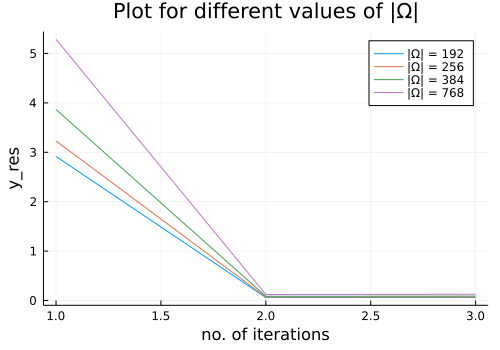

In [18]:
Ω = [192, 256, 384, 768]
X,list_1 = LRMCRec_ISTA(1,0.05,Ω[1],8)
X,list_2 = LRMCRec_ISTA(1,0.05,Ω[2],8)
X,list_3 = LRMCRec_ISTA(1,0.05,Ω[3],8)
X,list_4 = LRMCRec_ISTA(1,0.05,Ω[4],8)

plot(range(1,stop=length(list_1)),list_1, label = "|Ω| = 192")
plot!(range(1,stop=length(list_2)),list_2, label = "|Ω| = 256")
plot!(range(1,stop=length(list_3)),list_3, label = "|Ω| = 384")
display(plot!(range(1,stop=length(list_4)),list_4, label = "|Ω| = 768", 
        title = "Plot for different values of |Ω|", xlabel="no. of iterations", ylabel="y_res", windowsize=(500, 350)))

<u>**Summary Notes**</u>

Same as the performance of IHT algorithm, **performs better with smaller $|\Omega|$**, provides **faster convergence than IHT**.
<br>
<br>

<u>Plotting y_residue against number of iterations for different values of r .</u>

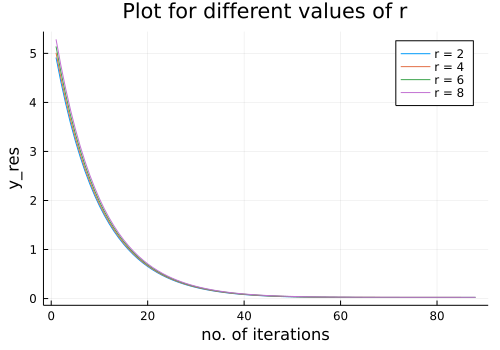

In [19]:
r = [2, 4, 6, 8]
X,list_1 = LRMCRec_ISTA(0.1,0.01,768,r[1])
X,list_2 = LRMCRec_ISTA(0.1,0.01,768,r[2])
X,list_3 = LRMCRec_ISTA(0.1,0.01,768,r[3])
X,list_4 = LRMCRec_ISTA(0.1,0.01,768,r[4])

plot(range(1,stop=length(list_1)),list_1, label = "r = 2")
plot!(range(1,stop=length(list_2)),list_2, label = "r = 4")
plot!(range(1,stop=length(list_3)),list_3, label = "r = 6")
display(plot!(range(1,stop=length(list_4)),list_4, label = "r = 8", 
        title = "Plot for different values of r", xlabel="no. of iterations", ylabel="y_res", windowsize=(500, 350)))

<u>**Summary Notes**</u>

The number of ranks doesn't seem to have a great impact on convergence
<br>

### <u>Plotting Ground Truth Error and Final Residue as Contour and Surface plot for varying values of τ and λ .</u>

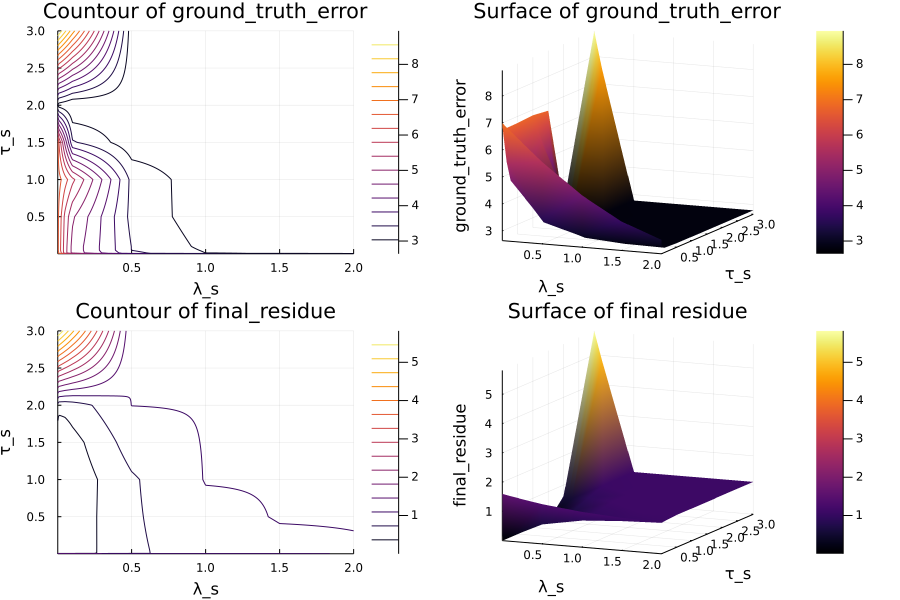

In [20]:
allow_run = false
if(allow_run)
    λ_s = [0.001,0.005, 0.01, 0.05, 0.1,0.5, 1,1.5,2]
    τ_s = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1,1.5,2,3]
    r = 8
    Ω = 192
final_residue = [(LRMCRec_ISTA(τ,λ,Ω,r)[4]) for τ in τ_s, λ in λ_s]
ground_truth_error = [(LRMCRec_ISTA(τ,λ,Ω,r)[3]) for τ in τ_s, λ in λ_s]
    str = string("ground_truth_error_plots3d.jld2")
    results = [λ_s,τ_s,final_residue,ground_truth_error]
    @save str results
else
    str = string("ground_truth_error_plots3d.jld2")
    @load str results
    λ_s,τ_s,final_residue,ground_truth_error = results
end
p1 = plot(contour(λ_s, τ_s, ground_truth_error, title="Countour of ground_truth_error", xaxis="λ_s", yaxis="τ_s", fill=false))
p2 = plot(surface(λ_s, τ_s, ground_truth_error, title="Surface of ground_truth_error", xlabel="λ_s", ylabel="τ_s", zlabel="ground_truth_error"))
p3 = plot(contour(λ_s, τ_s, final_residue, title="Countour of final_residue", xaxis="λ_s", yaxis="τ_s", fill=false))
p4 = plot(surface(λ_s, τ_s, final_residue, title="Surface of final residue", xlabel="λ_s", ylabel="τ_s", zlabel="final_residue"))
display(plot(p1, p2, p3, p4,layout = (2, 2), legend = false, windowsize=(900, 600)))

<u>**Summary Notes**</u>

In conclusion, **smaller $|\Omega|$** values provide **faster convergence**. <br>

The number of rank r seems to be **insignificant** to the rate of convergence here **compared to IHT**. <br>

Every $|\Omega|$ values can give **full recovery** of the matrix in ISTA. <br>

**Bigger lambda** gives **higher residue** but **smaller ground truth error**. <br>

<a id='3.2.4Lasso-ADMM'></a>
## 3.2.4 Lasso-ADMM (25%)

Design, implement, and run simple tests for an ADMM algorithm (to solve the Lasso formulation) for low-rank matrix completion. Use the function name `LRMCRec_ADMM`. Provide necessary documentation. Compare ADMM and ISTA in terms of convergence.

<u>**Brief explaination of ADMM function**</u>

For the ADMM algorithm we need to minimise the Lasso expression:<br>

$min \frac{1}{2}\|y-Ax\|^2_2+\|\lambda\|_1$  <br>

This can be broken up into 3 steps: <br>
$$
      step1:x^{(k+1)}=\mathop{\arg\min}\limits_{x}\|y-Ax\|^2_2+\frac{ρ}{2}\|x-z^k+\frac{v^k}{\rho}\|_2^2 \\
      step2:z^{(k+1)}=\mathop{\arg\min}\limits_{z}\lambda \|z\|_1+\frac{ρ}{2}\|x^{k+1}-z+\frac{v^k}{\rho}\|_2^2\\
      step3:v^{(k)}=v^k+\rho(x^{k+1}-z^{k+1})
$$

For step1, in order to get the closed form for update we take the deriative of step1 with respect to x,and set it to 0 <br>

$-A^T(y-Ax^*) + \rho(x^*-z^k+\frac{v^k}{\rho}) = 0$ <br>

And we get, operation 1: $x^* = (A^TA+\rho I)^{-1}(A^Ty+\rho z^k-v^k)$ <br>

For step 2, we have also take the deriative to the expression with respect to z,and set it to 0. <br>
$z^*=x^{k+1}+\frac{v^k}{\rho}$ <br>
Since this expression has a L1 norm component and therefore similiar to the ISTA case for the low rank completion problem, we apply a soft threshold operation in the function to appose the restriction. <br>

Finally, for operation 3: we directly use the closed form expression in **step 3 to update the value** $v^{k+1}$ 

In [21]:
function LRMCRec_ADMM(ρ,Ω,r,λ)
    m = 32
    n = 48
    X,A,y,T = LRMC_data_gen(m,n,r,Ω)
    
    x_l = vec(RandomGaussianMatrix(m,n))
    v = RandomGaussianMatrix(m*n,1)
    z = copy(x_l)

    iters = 1
    current_norm = norm(y - A * x_l) 
    past_norm = copy(current_norm)
    residues = []
    while true
        
        x_l = pinv(A' * A + ρ * Matrix{Float64}(I,m*n,m*n)) * (A' * y + ρ .* z - v)

        z = x_l + (1/ρ) .* v
        z = reshape(z,m,n)
        U,Σ,V = full_svd_detail(z)
        for i in 1:m
            if Σ[i,i] < λ/ρ                      #Σ[i,i] always non-negative
                Σ[i,i]=0
            else 
                Σ[i,i] -= λ/ρ
            end
        end
        z = vec(U * Σ * V')
        

        v = v + ρ .* (x_l - z)
        
        current_norm = norm(y - A * x_l)
        residues = push!(residues,current_norm)
        iters += 1
        if (iters >= 300 || current_norm < 1e-4)
            break
        end
        
        past_norm = current_norm
    end

    return x_l,residues,norm(vec(X) - x_l),current_norm
end

LRMCRec_ADMM (generic function with 1 method)

## Testing the LRMRec_ADMM

<u>Plotting residue against iterations for different values of p when |Ω| = 192.</u>

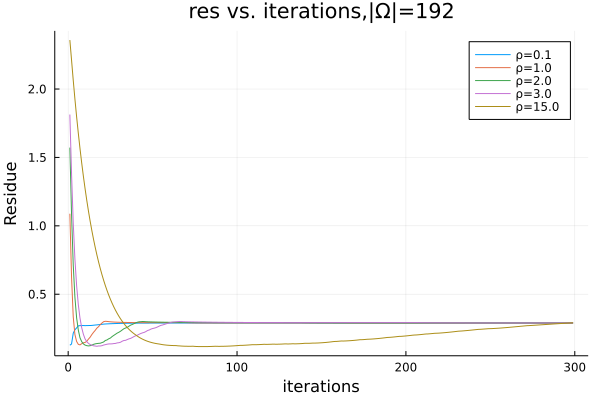

In [22]:
using Plots
allow_run = false
if(allow_run)
    p = Plots.Plot{Plots.GRBackend}
    ρ_s = [0.1, 1, 2, 3,15] #Trying out different ρ values
    for ρ in ρ_s 
    norms = LRMCRec_ADMM(ρ,192,2,0.1)[2]
        if(ρ == ρ_s[1])
            p = plot(range(1,stop=length(norms)),norms,label="ρ=$(ρ)", title="res vs. iterations,|Ω|=192",ylabel="Residue", xlabel="iterations", fmt = :png,dpi=100)
        else
            p = plot!(range(1,stop=length(norms)),norms,label="ρ=$(ρ)", title="res vs. iterations,|Ω|=192",ylabel="Residue", xlabel="iterations", fmt = :png,dpi=100)
        end
    str = string("ADMM_plots_res_iteration.jld2")
    results = p
    @save str results
    end 
else 
    str = string("ADMM_plots_res_iteration.jld2")
    @load str results
    p = results
end
display(plot(p))

<u>**Summary Notes**</u>

No matter what the value of $\rho$ they would always **converge to the same residue after enough iterations**. 
Each of them, **except for small $\rho$ values like $\rho$ = 0.1**, will have an **undershoot**, and the minimum point for each $\rho$ are all the same.

Hence, whatever the value of $\rho$ is, **ADMM always converges**.

<u>Plotting y_residue against no. of iterations for different values of r.</u>

If we choose the regular L1 norm in operation 2 for restriction the residue will not have an undershoot,however the ground truth error in the end will be significantly higher

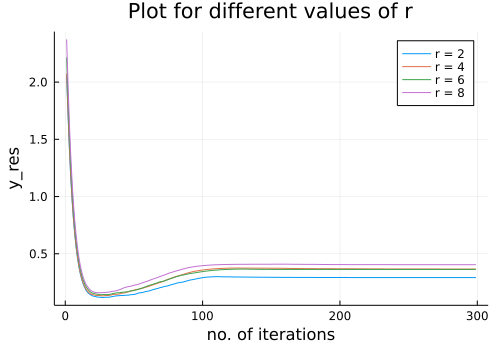

In [23]:
allow_run = false
if(allow_run)
        norms1 = LRMCRec_ADMM(5,192,2,0.1)[2]
        norms2 = LRMCRec_ADMM(5,192,4,0.1)[2]
        norms3 = LRMCRec_ADMM(5,192,6,0.1)[2]
        norms4 = LRMCRec_ADMM(5,192,8,0.1)[2]
        str = string("ADMM_plots_r_iteration.jld2")
        results = norms1,norms2,norms3,norms4
        @save str results
else
        str = string("ADMM_plots_r_iteration.jld2")
        @load str results
        norms1,norms2,norms3,norms4 = results
end
plot(range(1,stop=length(norms1)),norms1, label = "r = 2")
plot!(range(1,stop=length(norms2)),norms2, label = "r = 4")
plot!(range(1,stop=length(norms3)),norms3, label = "r = 6")
display(plot!(range(1,stop=length(norms4)),norms4, label = "r = 8", 
        title = "Plot for different values of r", xlabel="no. of iterations", ylabel="y_res", windowsize=(500, 350)))

<u>**Summary Notes**</u>

For **ADMM**, **lower ranks** gives **lower residue**, unlike **IHT(larger rank gives lower residue)** or **ISTA(insignificant relationship)**.

<u>Plotting y_residue against no. of iterations for different values of |Ω|.</u>

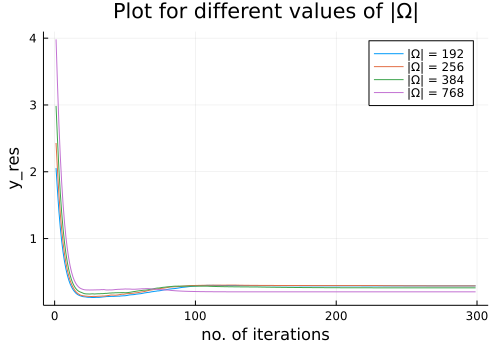

In [24]:
allow_run = false
if(allow_run)
        list_1 = LRMCRec_ADMM(5,192,2,0.1)[2]
        list_2 = LRMCRec_ADMM(5,256,2,0.1)[2]
        list_3 = LRMCRec_ADMM(5,384,2,0.1)[2]
        list_4 = LRMCRec_ADMM(5,768,2,0.1)[2]
        str = string("ADMM_plots_Ω_iteration.jld2")
        results = list_1,list_2,list_3,list_4
        @save str results
else
        str = string("ADMM_plots_Ω_iteration.jld2")
        @load str results
        list_1,list_2,list_3,list_4 = results
end

plot(range(1,stop=length(list_1)),list_1, label = "|Ω| = 192")
plot!(range(1,stop=length(list_2)),list_2, label = "|Ω| = 256")
plot!(range(1,stop=length(list_3)),list_3, label = "|Ω| = 384")
display(plot!(range(1,stop=length(list_4)),list_4, label = "|Ω| = 768", 
        title = "Plot for different values of |Ω|", xlabel="no. of iterations", ylabel="y_res", windowsize=(500, 350)))

<u>**Summary Notes**</u>

For ADMM,different $\Omega$ values do not seems to have relationships on the convergence
<br>
<br>

<u>Plotting Ground Truth Error against rank, λ, ρ and |Ω| .</u>

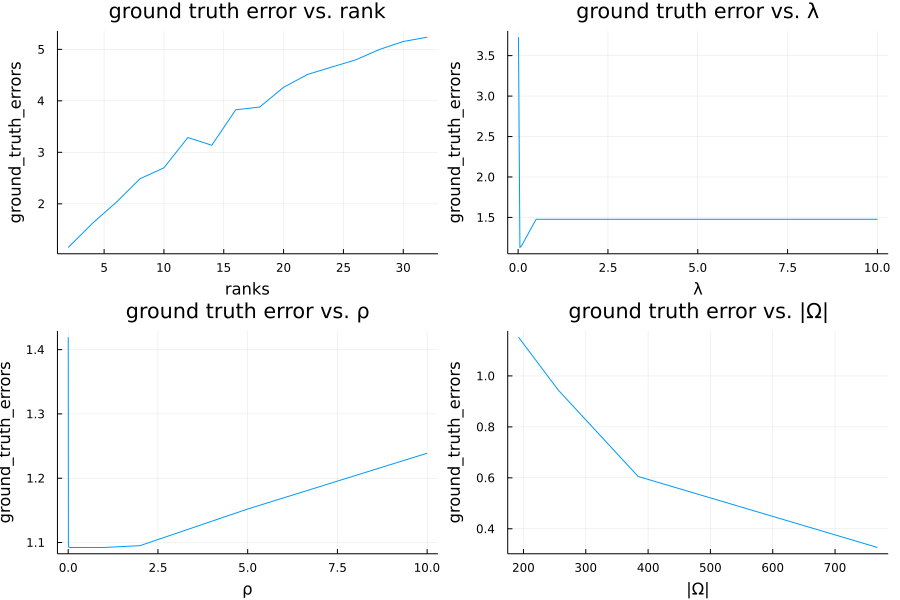

In [25]:
using Plots
using JLD2
allow_run = false
if(allow_run)
    ground_truth_errors_r = [(LRMCRec_ADMM(5,192,r,0.1)[3]) for r in 2:2:32]
    ground_truth_errors_λ = [(LRMCRec_ADMM(5,192,2,λ)[3]) for λ in (λ_s = [ 0.01, 0.05,0.1,0.5,1,2,5,10])]
    ground_truth_errors_ρ = [(LRMCRec_ADMM(ρ,192,2,0.1)[3]) for ρ in (ρ_s = [0.0001,0.0005,0.001,0.005, 0.01, 0.05,0.1,0.5,1,2,5,10])]
    ground_truth_errors_Ω =[(LRMCRec_ADMM(5,Ω,2,0.1)[3]) for Ω in (Ω_s = [192,256,384,768])]
    str = string("ground_truth_error_plots_ADMM.jld2")
    results = [ground_truth_errors_r,ground_truth_errors_λ,λ_s,ground_truth_errors_ρ,ρ_s,ground_truth_errors_Ω,Ω_s]
    @save str results
else
    str = string("ground_truth_error_plots_ADMM.jld2")
    @load str results
    ground_truth_errors_r,ground_truth_errors_λ,λ_s,ground_truth_errors_ρ,ρ_s,ground_truth_errors_Ω,Ω_s = results
end
p1 = plot([2:2:32],ground_truth_errors_r,title = "ground truth error vs. rank",xlabel = "ranks", ylabel = "ground_truth_errors")
p2 = plot(λ_s,ground_truth_errors_λ,title = "ground truth error vs. λ",xlabel = "λ", ylabel = "ground_truth_errors")
p3 = plot(ρ_s,ground_truth_errors_ρ,title = "ground truth error vs. ρ",xlabel = "ρ", ylabel = "ground_truth_errors")
p4 = plot(Ω_s,ground_truth_errors_Ω,title = "ground truth error vs. |Ω|",xlabel = "|Ω|", ylabel = "ground_truth_errors")
display(plot(p1, p2, p3, p4,layout = (2, 2), legend = false, windowsize=(900, 600)))

<u>**Summary Notes**</u>

We can observe that **higher ranks gives higher final ground truth error**, just like other algorithms.

There is an **optimum point of $\lambda$** which provides **lowest ground truth error around 0.1**. <br>

**Too small $\rho$** values **gives higher ground truth error**, **beyound 2 diverges**, same as ISTA and IHT. <br>

Also, similiar to IHT and ISTA, ground truth error decreases with the increase of number of revealed index.

<br>

### <u>Plotting Ground Truth Error and Final Residue as Contour and Surface plot for varying values of Ω and λ .</u>

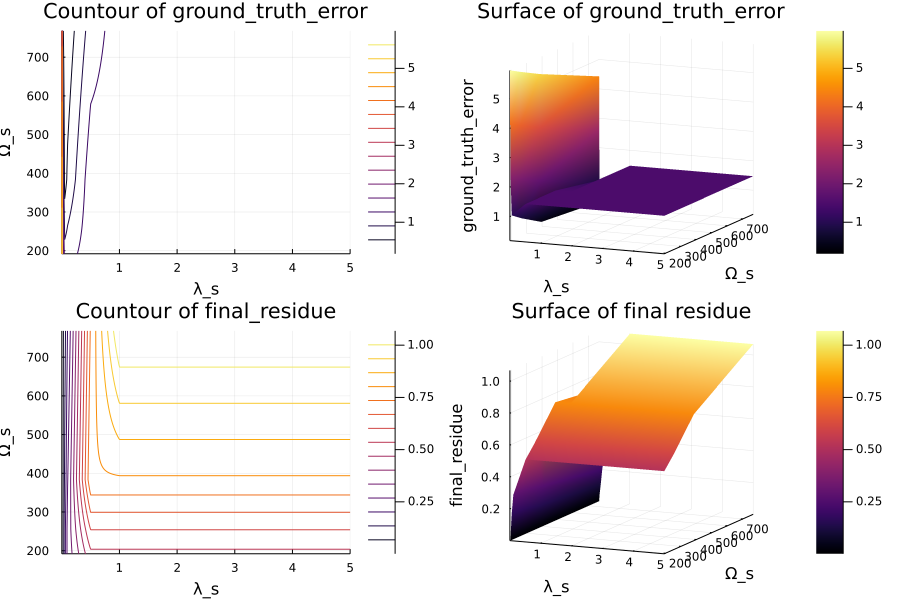

In [26]:
allow_run = false
if(allow_run)
    λ_s = [0.001,0.005, 0.01, 0.05, 0.1,0.5, 1,5]
    Ω_s = [192,256,384,768]
final_residue = [(LRMCRec_ADMM(3,Ω,2,λ)[4]) for Ω in Ω_s, λ in λ_s]
ground_truth_error = [(LRMCRec_ADMM(3,Ω,2,λ)[3]) for Ω in Ω_s, λ in λ_s]
    str = string("ground_truth_error_plots3d_ADMM.jld2")
    results = [λ_s,Ω_s,final_residue,ground_truth_error]
    @save str results
else
    str = string("ground_truth_error_plots3d_ADMM.jld2")
    @load str results
    λ_s,Ω_s,final_residue,ground_truth_error = results
end
p1 = plot(contour(λ_s, Ω_s, ground_truth_error, title="Countour of ground_truth_error", xaxis="λ_s", yaxis="Ω_s", fill=false))
p2 = plot(surface(λ_s, Ω_s, ground_truth_error, title="Surface of ground_truth_error", xlabel="λ_s", ylabel="Ω_s", zlabel="ground_truth_error"))
p3 = plot(contour(λ_s, Ω_s, final_residue, title="Countour of final_residue", xaxis="λ_s", yaxis="Ω_s", fill=false))
p4 = plot(surface(λ_s, Ω_s, final_residue, title="Surface of final residue", xlabel="λ_s", ylabel="Ω_s", zlabel="final_residue"))
display(plot(p1, p2, p3, p4,layout = (2, 2), legend = false, windowsize=(900, 600)))

<u>**Summary Notes for Comparing the convergence between ADMM and ISTA**</u>
<br>


In summary, for **ISTA**, **$\tau$ values within the threshold gives convergence**. 

Within the threshold, **bigger $\tau$ gives faster convergence**. For **ADMM**, **smaller $\rho$ gives faster convergence**. But **all $\rho$ > 0 gives convergences**.<br>

For **both ISTA and ADMM**, number of **ranks** of X matrix **does not impact the speed of convergence**. However for **ADMM**, **smaller rank values gives lower residue**,and for ISTA, the relationship between those two seems somewhat unrelated.<br>

One difference between ADMM and ISTA is that the **residue of ADMM would always have an undershoot**(except for small $\rho$ values) while ISTA does not. 

<a id='Highlight'></a>
# Highlight for Group 3

Please list a couple of highlights of your coursework that may impress your markers.

1. For each part of the coursework, **all of the questions have been answered fully in detail** along with additional           explaination and analysis. This includes going beyond orginial questions for AM, IHT, ISTA and ADMM.<br>
    <br>
2. The analysis for all parts includes **many graph plots to show case simple tests, choice of parameters or comparison       between algorithms**. All graphs are plotted well and prove our conclusions.<br>
    <br>
3. Code functions for parts have been **well written, commented and optimised**. All include break conditions as well.<br>
    <br>
4. Additional introductions have been included to help show how code functions were intially approached and then          designed, this does include some **mathematical derivations and worded explainations**.<br>
    <br>
5. We managed to complete the all of the Coursework even with one less member in the team due falling ill due to           Covid-19.<br>